# Input data processing for the Clean Cooking Explorer (CCE) and OnSSTOVE

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from onsstove.onsstove import DataProcessor

In [3]:
from decouple import config
import numpy as np
import os

## 1. Creating a project
First, we will create an instance of the `MCA` object that will be used to add raw datasets, process them and generate the required output datapackages for the CCE and OnSSTOVE. The `MCA` object accepts three optional argument `project_crs`, `cell_size` and `output_directory`. The first, sets the Coordinate reference System (crs) to use in the project, this means that all datasets will be reprojected to match such crs. The second, is used to define the desired cell size (i.e. width and height in meters) of the output datasets, which will be used to ensure that all output datasets match such cell size. The third, is simply used as the output folder in which all results will be writen, this parameter defaults to `output`.

In [4]:
nepal = DataProcessor(project_crs=3857, cell_size=(1000, 1000))
nepal.output_directory = 'output2' # Any of the attributes can be set at any time like this

## 2. Adding a PostgreSQL data base connection
Datasets can be read from any local path (or in some cases from urls) or from a PostgreSQL database. For the later, we would need to define the PostgreSQL connection, passing the database name `db`, the `POSTGRES_USER` and the `POSTGRES_KEY`.

In [5]:
nepal.set_postgres(db='nepal', POSTGRES_USER=config('POSTGRES_USER'), POSTGRES_KEY=config('POSTGRES_KEY'))

## 3. Adding a mask layer
A vector layer can be added as a mask, which will be later used to mask/clip all output datasets to the layer boundaries. For this, we use the `add_mask_layer` method providing a `name` for the layer, a `layer_path` from where to read the data and in this case the `postgres` argument as `True` that will tell that the layer is found in the PostgreSQL database.

In [6]:
nepal.add_mask_layer(name='Country boundaries', layer_path='admin.npl_admbnda_adm0_nd_20201117', postgres=True)

## 4. Adding data layers
Similarly, we can add data layers using the `add_layer` method. A layer `name`, `layer_path` and `postgres` conection also need to be provided (the `postgres` conection defaults to `False`). In addition, the following arguments can be passed:
* `category`: this is used to group all datasets into a category in the final output, e.g. `demand` or `supply`. 
* `layer_type`: thi argument is required with two possible options `raster` or `vector`, we should pass either one according to the dataset you are adding. 
* `distance`: the method to be used to calculate the distance raster for this layer. 
    * For `raster` layers, only `log` is available. This will create a logarithmic representation of the original raster. If this is not desired, we should pass `None` to the `distance` parameter (this is the defaul value), which will take the original raster as the distance raster.
    * For `vector` layers, two options are available `proximity` and `time_travel`. `proximity`, calculates a distance raster using the vectors (e.g. points, lines, polygons) as origin; the output raster will have the same dimentions and cell size as the `base_layer` (i.e. see below). `time_travel`, will need a friction raster (which can be added later) that will be used to calculate the least cost path to every cell taking the vectors as starting points.
* `normalization`: currently only `MinMax` normalization is available. This is used to normalize the distance rasters in a 0 to 1 range, which will be used later to calculate the CCE Demand, Supply and Clean Cooking potential indexes.
* `inverse`: we can specify if the scale of the ormalization need to be reversed, depending on the nature of the dataset.

In [7]:
nepal.add_layer(category='demand', name='Population', layer_path='data/population_npl_2018-10-01.tif',
                layer_type='raster', normalization='MinMax', inverse=False, 
                distance='log', base_layer=False, resample='sum')

nepal.add_layer(category='demand', name='Education facilities', layer_path='places.education_facilities', postgres=True,
                layer_type='vector', normalization='MinMax', inverse=True, 
                distance='proximity', distance_limit=5000)

nepal.layers['demand']['Population'].layer[np.isnan(nepal.layers['demand']['Population'].layer)] = 0
nepal.layers['demand']['Population'].save(os.path.join(nepal.output_directory, 'demand', 'Population'))

In [8]:
nepal.add_layer(category='demand', name='Health facilities', layer_path='places.health_facilities', postgres=True,
                layer_type='vector', normalization='MinMax', inverse=True, 
                distance='proximity', distance_limit=5000)

nepal.add_layer(category='supply', name='Existent transmission substations', layer_path='power_network.substations_georeferenced', 
                postgres=True, layer_type='vector', query='status == "E"', normalization='MinMax', inverse=True, 
                distance='proximity', distance_limit=30000)

nepal.add_layer(category='supply', name='Under Construction transmission substations', layer_path='power_network.substations_georeferenced', 
                postgres=True, layer_type='vector', query='status == "UC"', normalization='MinMax', inverse=True, 
                distance='proximity', distance_limit=30000)

nepal.add_layer(category='supply', name='Planned transmission substations', layer_path='power_network.substations_georeferenced', 
                postgres=True, layer_type='vector', query='status == "P"', normalization='MinMax', inverse=True, 
                distance='proximity', distance_limit=30000)

nepal.add_layer(category='supply', name='Existent HV lines', layer_path='power_network.hv_lines_georeferenced',
                postgres=True, layer_type='vector', query='status =="E"', normalization='MinMax', inverse=True, 
                distance='proximity', distance_limit=30000)

nepal.add_layer(category='supply', name='Planned HV lines', layer_path='power_network.hv_lines_georeferenced',
                postgres=True, layer_type='vector', query='status =="P"', normalization='MinMax', inverse=True, 
                distance='proximity', distance_limit=30000)

## 5. Adding a base layer
A raster base layer is needed to make every output match its grid and extent. For this, two additional options need to be passed to the `add_layer` method:
* `base_layer`: if `True` the added layer will be considered as the base layer. 
* `resample`: this is the resampling method to be used when resampling this layer to the desired `cell_size` if a `cell_size` is provided.

In [9]:
nepal.add_layer(category='supply', name='Biomass', layer_path='data/Forest cover/Global Forest Cover Change (GFCC).tif',
                layer_type='raster', normalization='MinMax', inverse=False, base_layer=True, resample='nearest',
                distance='travel_time', distance_limit=5)

## 6. Adding a friction raster to a vector layer
After adding a vector layer, a raster friction layer can be associated to the vector layer in order to calculate a travel time dataset for it. To do so, we can call the vector layer we want by using the `layers` variable and calling the `category` and the `name` of the vector dataset between quotes and square brackets, and calling the `add_friction_raster` method. This method only needs the path of the raster `raster_path`.

In [10]:
nepal.layers['supply']['Biomass'].add_friction_raster(raster=r"data\2020_walking_only_friction_surface\2020_walking_only_friction_surface.geotiff",
                                                      resample='average')

In [11]:
nepal.add_layer(category='supply', name='LPG dealers', layer_path='data/lpg_main_dealers/lpg_main_dealers.shp',
                postgres=False, layer_type='vector', normalization='MinMax', inverse=True, 
                distance='travel_time', distance_limit=2)

nepal.layers['supply']['LPG dealers'].add_friction_raster(raster=r"data\2020_motorized_friction_surface\2020_motorized_friction_surface.geotiff",
                                                          resample='average')

## 7. Mask and reproject layers

In [12]:
nepal.mask_layers(datasets='all')

In [13]:
nepal.reproject_layers(datasets='all')

In [14]:
nepal.align_layers(datasets='all')

## 8. Calculate distance rasters and normalize

In [15]:
nepal.get_distance_rasters(datasets='all')

In [16]:
nepal.layers

{'demand': {'Population': RasterLayer(name='Population'),
  'Education facilities': VectorLayer(name='Education facilities'),
  'Health facilities': VectorLayer(name='Health facilities')},
 'supply': {'Existent transmission substations': VectorLayer(name='Existent transmission substations'),
  'Under Construction transmission substations': VectorLayer(name='Under Construction transmission substations'),
  'Planned transmission substations': VectorLayer(name='Planned transmission substations'),
  'Existent HV lines': VectorLayer(name='Existent HV lines'),
  'Planned HV lines': VectorLayer(name='Planned HV lines'),
  'Biomass': RasterLayer(name='Biomass'),
  'LPG dealers': VectorLayer(name='LPG dealers')}}

## Scenarios

### E-cooking potential with current electricity infrastructure

In [17]:
nepal.layers['demand']['Education facilities'].distance_raster.distance_limit = 5000
nepal.layers['demand']['Health facilities'].distance_raster.distance_limit = 5000

nepal.layers['supply']['Existent HV lines'].distance_raster.distance_limit = 30000
nepal.layers['supply']['Existent transmission substations'].distance_raster.distance_limit = 30000

In [32]:
nepal.normalize_rasters(datasets='all')

In [33]:
nepal.layers['supply']['Existent HV lines'].weight = 1
nepal.layers['supply']['Existent transmission substations'].weight = 2

In [34]:
nepal.get_demand_index(datasets='all')
nepal.get_supply_index(datasets={'supply': ['Existent HV lines', 'Existent transmission substations']})
nepal.get_clean_cooking_index()

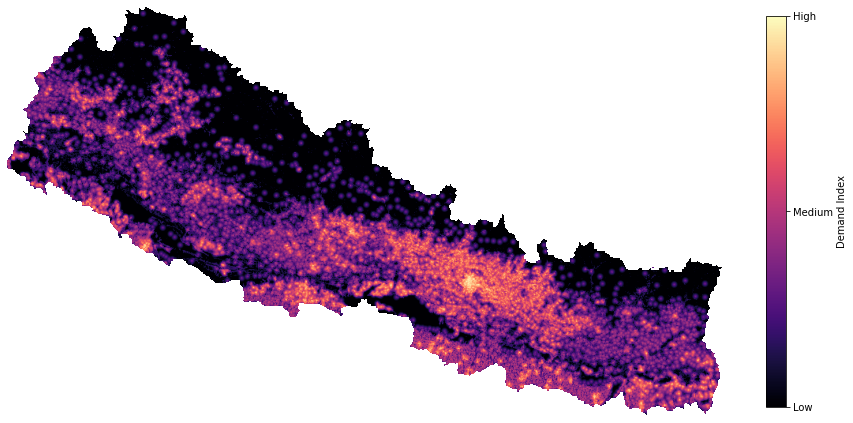

In [35]:
nepal.demand_index.plot()

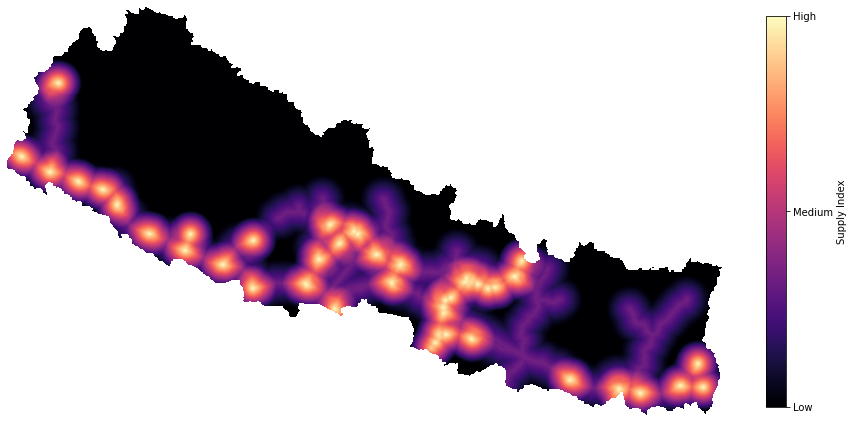

In [36]:
nepal.supply_index.plot()

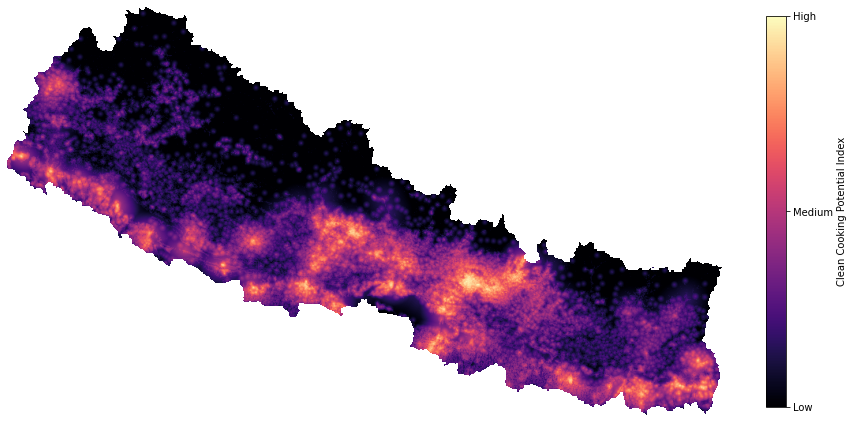

In [37]:
nepal.clean_cooking_index.plot()